# Inteligencia Colectiva

**Trabajo No. 2** 

1. Juan David Moreno Martinez
2. Luis Miguel Marulanda 
3. Mario Fernando Reyes Ojeda

### Crowdsensing y Smart Cities

El desarrollo de nuevas tecnologías con base disruptiva genera nuevos escenarios de aplicación de la tecnología. Tópicos como internet de las cosas, geolocalización, telecomunicaciones y el desarrollo de nuevas interfaces soportan hoy poder tener un contexto virtual instantáneo del real. El uso masificado de nuevos servicios y productos con esta base tecnológica propone facilitar la decisiones y acciones del ser humano respecto a su entorno.

Coherente a esto el concepto de **ciudades inteligentes** se relaciona al aprovechamiento de la tecnología para mejorar la cotidianidad de los ciudadanos desde la experiencia pasada y de otros, por tanto, la colaboración soporta la generación de una inteligencia colectiva que intenta beneficiar a todos. A nivel específico crowdsourcing utiliza la inteligencia colectiva para resolver problemas complejos dividiendo su resolución en tareas que la multitud puede ir resolviendo, de manera semejante **crowdsensing** propone la generación de información a la multitud para ofrecer recomendaciones, servicios o ayudas que puedan ser provechosas de acuerdo a su contexto o situación.


### Descripcion del Problema

Parte de la puesta en marcha de crowdsensing es establecer generadores de información. Gran parte de la cosecha de información que posteriormente genera valor es obtenida de la observación continua de un lugar, evento o situación durante un tiempo específico.

Es importante resaltar que uno de los grandes retos de crowdsensing es diversificar sus métodos de cosecha, por tanto, la multitud no puede estar limitada a un solo receptor de información o un solo mecanismo de interacción, al contrario, se deben desarrollar nuevos enfoques del aprovechamiento de estas interfaces y la implementación de estrategias para el almacenamiento, integración y normalización de la información aportada.

El trabajo desarrollado se suscribe a identificar nuevos mecanismos de integración de fuentes y generadores de información con base a una interface de localización para generar seeds de inteligencia colectiva. De manera específica se utilizará una origen de datos relacionado a la movilidad de la ciudad de Boston registrada por Waze y la utilización de la API de Google Places para construir un sistema de recomendación que soporte la experiencia de lugares tipificados y relacionados al punto destino registrado en la transacción hecha en Waze.


### Descripcion de Datos

Para el desarrollo del trabajo se utilizaron dos (2) datasets diferentes. El primer dataset consiste en datos de Waze (Waze Jam Data) el cual contiene información sobre el tráfico que está ocurriendo en determinado momento. Es importante resaltar que una de las formas en la que Waze se da cuenta de que hay tráfico en determinado lugar es por medio de las calificaciones/reporte que dan sus usuarios sobre el estado de la vía. Estructura del dataset:

Total registros: 45299
Total columnas: 17
Columnas relevantes: street (inicio ruta), city, country, endNode (destino ruta), Length, level (calificación 0-5), delay, uuid (ID usuario)
Origen datos: Boston, MA, US

El segundo “dataset” se obtiene por medio de la conexión a la API de Google places la cual entrega información de diferentes lugares como restaurantes, centros comerciales, parques, etc. El valor de este dataset reside en las calificaciones que han dado las diferentes personas, los lugares que han visitado y sus gustos personales, ya que es posible realizar recomendaciones a partir de estos datos.

Total registros: Depende del pull que se realice
Total columnas: 19
Columnas relevantes: id autor review, rating autor, rating del lugar, reviews asociados, dirección, geometría. 
Origen datos: Boston, MA, US


#### Carga del Dataset Waze

A continuación se hace la importación del dataset de Waze a traves de la libreria Pandas:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
usecols = [i for i in range(0,13)] + [14]
data = pd.read_csv('wazedata_clean.csv', sep = ',',
                   encoding = 'utf8', header=None, low_memory=False, usecols=usecols)
          
data.columns = ['inject_date', 'street', 'city', 'country', 
                'delay', 'endNode', 'Length', 'level', 'pubMillis', 'roadType', 'speed', 'uuid',
                'startTime', 'endTime']

# Convertir columna fecha en tipo fecha formato UTC
data['startTime'] = [datetime.strptime(d, '%m/%d/%Y %I:%M:%S %p') for d in data['startTime']]
data['endTime'] = [datetime.strptime(d, '%m/%d/%Y %I:%M:%S %p') for d in data['endTime']]

#### Acercamiento a la Serie de Tiempo Relacionada

Para comprender los datos relacionados a la movilidad registrada por Waze se realiza primero un acercamiento a la serie de tiempo asociada a la colección de datos.

In [161]:
dateserie=data.groupby('startTime')
timeq=pd.DataFrame(dateserie.size().reset_index(name = "ocurrencias"))

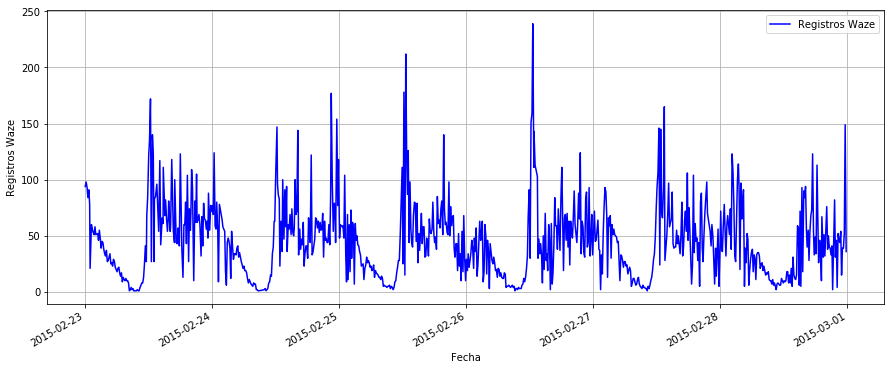

In [162]:
plt.figure()
tsdate = timeq.set_index('startTime')
tsdate.plot(figsize=(15, 6), color='b')
plt.ylabel('Registros Waze')
plt.xlabel('Fecha')
plt.legend(['Registros Waze'], loc=1)
plt.grid()
plt.show()

La grafica del campo **startTime** señala un comportamiento semejante durante 6 dias ( 23 de Febrero de 2015 a 1 de Marzo del 2015); no obstante para tener un mejor detalle de los registros se observa el atributo de hora de cada uno de los registros para el campo. De esta nueva observación se puede inferir alta movilidad desde el medio dia y luego un comportamiento constante con una ligera disminución durante las siguientes 12 horas.

In [172]:
data['startHourTime'] = [d.time() for d in data['startTime']]
ntime = data.groupby(by=[data.startHourTime.map(lambda x : (x.hour))])
n2time=pd.DataFrame(ntime.size().reset_index(name = "Registros Waze"))
newtime = n2time.set_index('startHourTime')

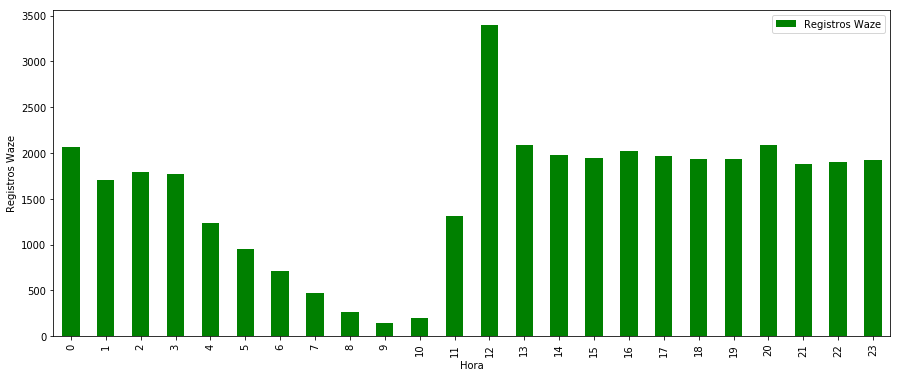

In [173]:
newtimep = newtime[['Registros Waze']].plot(kind='bar', figsize=(15, 6), color='g')
newtimep.set_xlabel("Hora")
newtimep.set_ylabel("Registros Waze")
plt.show()

#### Lugares de Destino (EndNodes)

Considerando que la fuente de datos relaciona el lugar de destino se propone analizar si existe algun comportamiento semejante relacioado a un lugar, de forma especifica se espera poder identificar puntos geográficos significativos en la movilidad de Boston. A continuacion se realiza la revisión de este atributo.

In [174]:
place_nodes=data.groupby('endNode', sort=True)
places_frame=pd.DataFrame(place_nodes.size().reset_index(name = "Group_Places"))
places_study = places_frame.sort_values('Group_Places', ascending=False)[:10]
places_study


,endNode,Group_Places
1210,Washington St,2087
736,Massachusetts Ave,935
118,Blue Hill Ave,908
336,Dorchester Ave,745
1134,Tremont St,741
267,Commonwealth Ave,705
560,Harvard St,640
126,Boylston St,615
612,Huntington Ave,608
184,Cambridge St,566


Del resultado obtenido se observa que existen puntos geográficos en común entre ellos Washington Street y Massachusetts Avenue, por tanto se plantea revisar la movilidad respecto al tiempo en busqueda de evidenciar algun comportamiento disimil del general.

#### Tiempo sobre _Washington St_

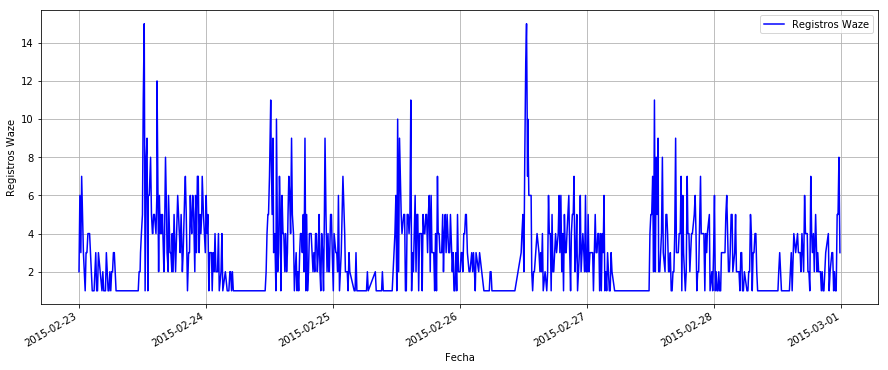

In [188]:
placew = data[data['endNode'] == "Washington St"]

ndate=placew.groupby('startTime')
newdate=pd.DataFrame(ndate.size().reset_index(name = "Group_Count"))

plt.figure()
tsdate = newdate.set_index('startTime')
tsdate.plot(figsize=(15, 6), color='b')
plt.ylabel('Registros Waze')
plt.xlabel('Fecha')
plt.legend(['Registros Waze'], loc=1)
plt.grid()
plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


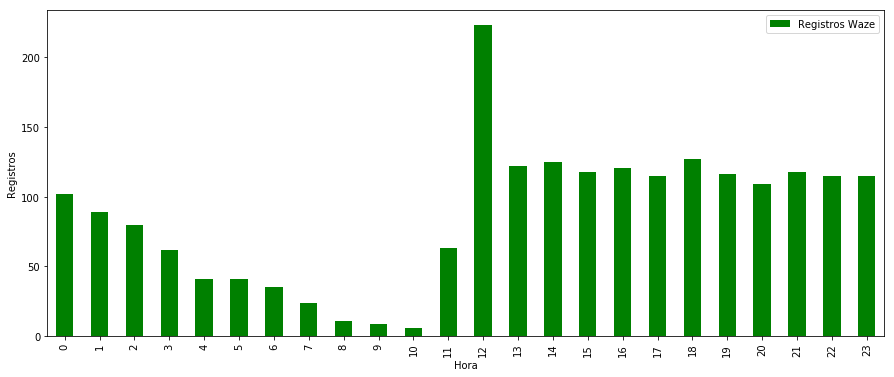

In [179]:
placew['startHourTime'] = [d.time() for d in placew['startTime']]
placew.head()

ntimew = placew.groupby(by=[placew.startHourTime.map(lambda x : (x.hour))])
n2timew=pd.DataFrame(ntimew.size().reset_index(name = "Registros Waze"))
newtimew = n2timew.set_index('startHourTime')

newtimepw = newtimew[['Registros Waze']].plot(kind='bar', figsize=(15, 6), color='g')
newtimepw.set_xlabel("Hora")
newtimepw.set_ylabel("Registros")
plt.show()

Se puede observar en la anteriores graficas que el comportamiento de Washington St no varia significativamente del analizado para toda la ciudad.

#### Tiempo de Espera (Delay)

De acuerdo a la información del dataset el campo _delay_ representa una estimador relacionado a la espera o congestión en la solicitud hecha al servicio de Waze. El valor -1 representa movilidad adecuada y se encuentra estrechamente relacionada al campo nivel que representa una calificación para la ruta.

In [190]:
delay=data.groupby('delay')
delaygroup=pd.DataFrame(delay.size().reset_index(name = "Ocurrencias"))
delay_sort = delaygroup.sort_values('Ocurrencias', ascending=False)[:10]
delay_sort


,delay,Ocurrencias
0,-1,759
38,73,460
41,76,458
39,74,455
37,72,453
31,66,451
35,70,445
33,68,441
26,61,438
25,60,434


### Obteniendo datos de Lugares respecto a los Puntos de Estudio

Para establecer una base de inteligencia colectiva basada en crowdsensing de los lugares que se identificaron como significativos del dataset de Waze se plantea utilizar la API Places de Google que soporta lugares referenciados por otras personas previamente. Para realizar este proceso se implementaron handlers e interfaces para hacer el consumo de la API de forma personalizable. A continuacion se carga el codigo relacionado.  

In [193]:
# %load main.py
import json
import csv
import configparser

import collectivegmaps


class HandlerData(object):

    def __init__(self):
        self.config = configparser.ConfigParser()

    def loadconfig(self):
        self.config.read('apicredentials.ini')

        API_KEY_LOCATIONS = self.config['credentials']['geolocation']
        API_KEY_PLACES = self.config['credentials']['places']

        self.clocations = collectivegmaps.CollectiveLocations(
            API_KEY_LOCATIONS)
        self.cplaces = collectivegmaps.CollectivePlaces(API_KEY_PLACES)

    def search_location(self, textplace):
        result = self.clocations.get_geolocation(textplace)
        location_coor = result[0]['geometry']['location']
        location = (location_coor['lat'], location_coor['lng'])
        return location

    def get_place_information(self, placeId):
        result = self.cplaces.place_details(placeId)
        place = result['result']
        return place

    def search_places_radar(self, location, keyword, **kwargs):
        result = self.cplaces.search_places_radar(location, keyword, **kwargs)
        places_set = result['results']
        return places_set

    def search_places_near_position(self, location, keyword, type_rank):
        result = self.cplaces.search_places_nearby(
            location, keyword, type_rank)

    def search_places_text(textplace, location):
        result = self.cplaces.search_places_text(textplace, location)


def pulling_data(place, num_items):
    places_store = dict()
    handler = HandlerData()
    handler.loadconfig()

    geocode = handler.search_location(place)

    parameters = {'min_price': None, 'max_price': None}
    place_types = ['restaurant', 'store', 'bar', 'cafe']

    for tp in place_types:
        places_store[tp] = list()
        places = handler.search_places_radar(geocode, tp, **parameters)
        print("Places Found: %s" % len(places))

        count = ind = 0

        while (count < num_items and ind < len(places)):
            placed = places[ind]
            detail = handler.get_place_information(placed['place_id'])

            if 'rating' in detail.keys() and 'reviews' in detail.keys():
                places_store[tp].append(detail)
                count += 1

            ind += 1

    return places_store

handler = HandlerData()
handler.loadconfig()


Para cada lugar se realiza la consulta a la API de Google Places de maximo 100 lugares cercanos en un radio de 1 Kilometro.

In [133]:
bigplace_store = dict()

for place in places_study['endNode']:
    place_string = "%s, Boston MA" % place
    related_places = pulling_data(place_string, 100)
    bigplace_store[place] = related_places
    

Places Found: 37
Places Found: 99
Places Found: 21
Places Found: 34
Places Found: 72
Places Found: 67
Places Found: 37
Places Found: 48
Places Found: 20
Places Found: 36
Places Found: 11
Places Found: 21
Places Found: 58
Places Found: 112
Places Found: 48
Places Found: 46
Places Found: 196
Places Found: 196
Places Found: 140
Places Found: 161
Places Found: 20
Places Found: 21
Places Found: 13
Places Found: 23
Places Found: 36
Places Found: 60
Places Found: 22
Places Found: 35
Places Found: 187
Places Found: 197
Places Found: 156
Places Found: 111
Places Found: 178
Places Found: 145
Places Found: 99
Places Found: 159
Places Found: 192
Places Found: 198
Places Found: 187
Places Found: 178


### Sistema de Recomendación de Lugares

A partir de la información de lugares obtenida de la API Google Places a los puntos de destino más significativos identificados de los registros de Waze se propone desarrollar un sistema de recomendación basado en la experiencia de los usuarios que han realizado reviews previamente.

La implementación es una adaptacion de la propuesta para construir un sistema de recomendación para Yelp. La implementación original puede ser referenciado en: http://csidsocialmedia.github.io/2014/04/04/A-Recommedation-system-based-on-Yelp-data.html

In [135]:
# Importacion de Librerias Adicionales
import random
import numpy as np
from scipy.stats.stats import pearsonr


La implementación utiliza la correlación de Pearson como medida de similaridad entre dos lugares y de acuerdo a la evaluación y experiencia del usuario buscará un lugar de acuerdo a sus preferencias. Una medida de similaridad como el coeficiente de Pearson explica que mientras el valor aumente mayor afinidad tiene los items asociados.

In [138]:
def sim_pearson(prefs,p1,p2):
    a = [(i, prefs[p1][i], prefs[p2][i]) for i in prefs[p1] if i in prefs[p2]]
    if a and len(a) > 1:
        b = np.array(a)[:,1:].astype(float)
        return pearsonr(b[:,0], b[:,1])[0]
    else:
        return 0

def topMatches(prefs,p1,n=5, similarity=sim_pearson):
    scores=[(similarity(prefs,p1,other),other)
                   for other in prefs if other!=p1]
    scores.sort()
    scores.reverse( )
    return scores[0:n]

def calculateSimilarItems(prefs,n=10):
    result={}
    c=0
    for item in prefs:
        c+=1
        if c%1000==0: print("%d / %d" %(c,len(prefs)))
        scores=topMatches(prefs,item,n=n,similarity=sim_pearson)
        result[item]=scores
    return result



Para construir la base de experiencias y evaluaciones de los lugares y los usuarios se realiza un map a partir de sus opiniones. El siguiente codigo homologa la estructura propuesta para el dataset de Yelp e inicializa las estructura de forma semejante con la variación para el caso de los objetos entregados por Google Places.

In [194]:
users_struct = dict() 
places_struct = dict()

U = dict()
P = dict()

# Para el lugar Washington St
keyplace = 'Washington St'
restype = 'restaurant'

places= bigplace_store[keyplace][restype]

for pl in places:
    place = pl['place_id']
    rate_place = pl['rating']

    if place not in P:
        P[place] = pl

    for r in pl['reviews']:
        if 'author_url' not in r.keys():
            continue

        user = r['author_url'].split("/")[-2]
        if user not in U:
            U['user'] = {'name': r['author_name'], 'url':r['author_url'], 'userId': user }
        
        rate_user = r['rating']
        
        if place not in places_struct:
            places_struct[place] = dict()
        else:
            places_struct[place][user] = rate_user
            
        if user not in users_struct:
            users_struct[user] = dict()
        else:
            users_struct[user][place] = rate_user

itemsim=calculateSimilarItems(places_struct)

In [195]:
topshops={}
for i in places_struct:
    rates=list(places_struct[i].values())
    mean=np.mean(rates)
    if mean ==5:
        topshops[i]=len(rates)

topshops = [(score,item) for item,score in topshops.items()]
topshops.sort()
topshops.reverse()
topshops = [(5.0,j) for i,j in topshops[:5]]

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [196]:
def getRecommendedItems(prefs,itemMatch,user):
    userRatings=prefs[user]
    scores={}
    totalSim={}
    # Loop over items rated by this user
    for (item,rating) in userRatings.items():
             # Loop over items similar to this one
             for (similarity,item2) in itemMatch[item]:
                    # Ignore if this user has already rated this item
                    if item2 in userRatings: continue
                    # Weighted sum of rating times similarity
                    scores.setdefault(item2,0)
                    scores[item2]+=similarity*rating
                    # Sum of all the similarities
                    totalSim.setdefault(item2,0)
                    totalSim[item2]+=similarity
    # Divide each total score by total weighting to get an average 
    rankings=[(score/totalSim[item],item) for item,score in scores.items() if score>0]
    # Return the rankings from highest to lowest 
    rankings.sort( )
    rankings.reverse( )
    if rankings:
        return  [(i,P[j]['name']) for i,j in rankings[:10]]
    else:
        return  [(i,P[j]['name']) for i,j in topshops]


getRecommendedItems(users_struct,itemsim,random.sample(users_struct.keys(),1)[0])


[(5.0, "Nick's Restaurant"),
 (5.0, 'The Take Away'),
 (5.0, 'One Bistro'),
 (5.0, 'Minas Cafe Steakhouse')]